In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyproj 
from scipy.interpolate import griddata
import pickle 
from multiprocessing import Pool


def load_RCM(RCM_name, year, season = None): 
    '''
    Function that loads in RCM from one netcdf-file 
    
    Input: RCM_name: Name of RCM. For HIRHAM I have merged daily files into one using cdo mergetime.
           year: year 
           season: Due to the large size of RACMO you can only load in 3 month at a time and you 
                   need to sepcify which 3 month to import. 
    
    Output: polar_lat, polar_lon; Coordinates in EPSG:3413. 
            melt_data: Data from netcdf file. Full year for MAR and HIRHAM and only 3 month for RACMO.
    '''

    if RCM_name == 'RACMO': 
        # Import Racmo, due to large dataset the annual files are devided into 4:
        if season == 'JFM':
            RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_JFM.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc' )
        elif season == 'AMJ': 
            RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc' )
        elif season == 'JAS': 
            RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_JAS.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc' )            
        elif season == 'OND':
            RCM = xr.open_dataset(home_dir + f'/RACMO2.3/Daily-1km/snowmelt.{year}_OND.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc' )
        
        # extract data as a array
        melt_data = RCM.snowmeltcorr.data
        
        # convert into m from km:
        polar_lat = RCM.LAT.data*1000
        polar_lon = RCM.LON.data*1000
        
    elif RCM_name == 'MAR': 
        # import nc-file:
        RCM= xr.open_dataset(home_dir + f'/marv3.12/MARv3.12.1-10km-daily-ERA5-{year}.nc')
        
        # Get meltdata as a array:
        melt_data = RCM.ME.data.squeeze()
        
        # Convert into m from km: 
        polar_x = RCM.x.data*1000
        polar_y = RCM.y.data*1000
        
        polar_lon,polar_lat = np.meshgrid(polar_x, polar_y)
        
    elif RCM_name == 'HIRHAM': 
        # Import nc-file: 
        RCM =  xr.open_dataset(home_dir + f'/HIRHAM/{year}/HIRHAM_{year}.nc')
        melt_data = RCM.snmel.data.squeeze()
        
        # Get latlon coordinates:
        lon = RCM.lon.data 
        lat = RCM.lat.data 
        
        # Transform into EPSG 3413 using pyproj:
        transformer = pyproj.Transformer.from_crs('EPSG:4326','EPSG:3413')  
        polar_lon,polar_lat = transformer.transform(lat,lon)
        
    return polar_lat, polar_lon, melt_data

def load_yearly_RCM(RCM_name, year): 
    
    '''
    Function that loads a specific year of the RCM. Since RACMO are devided into seasonal files each file 
    needs to loaded sperately and combined. The rest of the RCMs are loaded from one file only. 
    
    Input: RCM_name: Name of RCM. For HIRHAM I have merged daily files into one using cdo mergetime.
           year: year 
    
    Output: polar_lat, polar_lon; Coordinates in EPSG:3413. 
            melt_data: Annual melt data from specified RCMS as an array. 
    
    '''   
    if RCM_name == 'RACMO': # Only for RACMO since files are too big to be loaded in at once.
        # Now we import a year and one RCM for the full year: (always on the same grid no matter the season)
        polar_lat, polar_lon, melt_dataJFM = load_RCM(RCM_name, year, season = 'JFM')
        _, _, melt_dataAMJ = load_RCM(RCM_name, year, season = 'AMJ')
        _, _, melt_dataJAS = load_RCM(RCM_name, year, season = 'JAS')
        _, _, melt_dataOND = load_RCM(RCM_name, year, season = 'OND')
        
        # Combine into one full year:
        melt_data = np.vstack((melt_dataJFM, melt_dataAMJ, melt_dataJAS, melt_dataOND))
    else: # All other RCMs:
        polar_lat, polar_lon, melt_data = load_RCM(RCM_name, year)
        
    return polar_lat, polar_lon, melt_data


def grid_data(lat_ori, lon_ori, var_ori, ref_lat, ref_lon, method_name):
    
    '''
    Function used to interpolate/regrid melt data to the ASCAT grid (in this case). Important that the original 
    grid and new grid is in the same projection (in this case EPSG:3413)
    
    Input: lat_ori, lon_ori: coordinates of the original grid (2D arrays)
           var_ori: Data to be regridded on the original grid (2D arrays).
           ref_lon, ref_lat: 
           method: 
    
    Output: (melt)Data on the new grid. 
    '''
   
    grid_var = griddata((lon_ori.flatten(), lat_ori.flatten()), var_ori.flatten(), (ref_lon, ref_lat), method=method_name)

    return grid_var

# Function for multiprocessing the regridding of melt data: 
def multiprocess_griddig(doy):
    '''
    Function used for multiprocessing of the regridding of data. Depending on the resolution of the RCM, the method
    of the regridding might need to be changed. 
    
    Input: doy: day of the year 
    
    Outout: grid_var: Data on the new grid for the given day of the year. 
    '''
    
    data_var = melt_data[doy]
    grid_var = np.flipud(grid_data(polar_lat, polar_lon, data_var, tif_lat, tif_lon, 'nearest'))
    return grid_var
    

# Choose RCM and year to regrid 

In [2]:
home_dir = '/home/annpug/Desktop/annpug'
# Choose RCM and year:
RCM_name = 'MAR'
year = 2012

# Now we import a year and one RCM for the full year: 
polar_lat, polar_lon, melt_data= load_yearly_RCM(RCM_name, year)

# Open nc file with the desired grid; (Made using gdal_translate)
tif_grid = xr.open_dataset(home_dir + '/tif_grid.nc')

# Generate ASCAT grid: 
tif_x = tif_grid.x
tif_y = tif_grid.y
tif_lon, tif_lat = np.meshgrid(tif_x,tif_y)

# Perform regridding and plot 

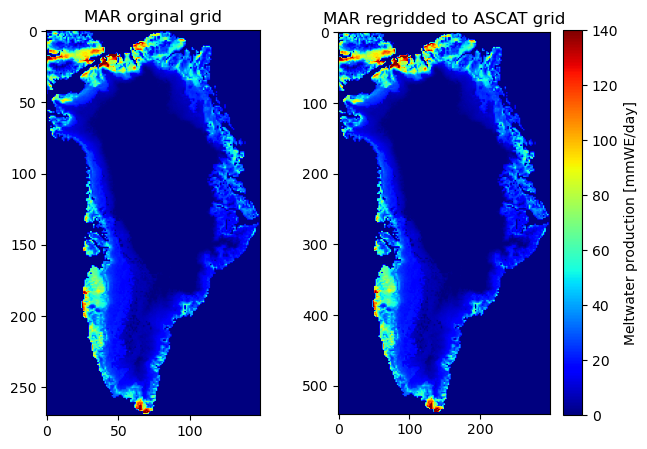

In [3]:
# Day of the year. 
doy = np.arange(0,np.size(melt_data,0))

# Regrid using multiprossing. Remember to check if the method is correct in the function definition.
pool = Pool()
pool_output = pool.map(multiprocess_griddig,doy)
pool.close()
pool.join 

# Reshape results:
data_regrid_shape = (np.size(melt_data,0), 540,299)
melt_regridded = np.reshape(pool_output, data_regrid_shape)

# Save as pickle:
with open(f'/home/annpug/Desktop/annpug/regriddedRCM/{RCM_name}_{year}_regridded_nearest.pkl','wb') as f:
    pickle.dump(melt_regridded, f)

# Plot orginal data and regridded data; 
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7.5,5))
ax2.imshow(melt_regridded[200],vmin = 0, vmax = 140,cmap ='jet')
im = ax1.imshow(np.flip(melt_data[200],0),vmin = 0, vmax = 140, cmap= 'jet' )
ax1.set_title(f'{RCM_name} orginal grid')
ax2.set_title(f'{RCM_name} regridded to ASCAT grid')
plt.colorbar(im, ax = ax2, label = 'Meltwater production [mmWE/day]')